In [1]:
import os, glob, random, math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# 재현성
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

plt.rcParams["figure.dpi"] = 140

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, k: int = 5, dilation: int = 1, dropout: float = 0.1):
        super().__init__()
        pad = (k - 1) * dilation // 2
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size=k, padding=pad, dilation=dilation)
        self.bn = nn.BatchNorm1d(out_ch)
        self.drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = F.gelu(x)
        return self.drop(x)

class SmallTCNEncoder(nn.Module):
    def __init__(self, in_ch: int = 2, hidden: int = 64, layers: int = 4, emb_dim: int = 64, dropout: float = 0.1):
        super().__init__()
        blocks = []
        ch = in_ch
        for i in range(layers):
            blocks.append(ConvBlock(ch, hidden, k=5, dilation=2 ** i, dropout=dropout))
            ch = hidden
        self.net = nn.Sequential(*blocks)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden, emb_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # x: (B,C,L)
        h = self.net(x)
        h = self.pool(h).squeeze(-1)
        z = self.fc(h)
        z = F.normalize(z, dim=-1)
        return z


In [3]:
ckpt_path = "byol_tcn_encoder_shape_first_v02.pt"  # 필요시 수정
ckpt = torch.load(ckpt_path, map_location="cpu")

emb_dim = int(ckpt["emb_dim"])
window = int(ckpt["window"])
vol_lookback = int(ckpt["vol_lookback"])
smoothing_window = int(ckpt.get("smoothing_window", 0))

# 모델 파라미터가 저장돼 있다면 반영
model_cfg = ckpt.get("model", {})
hidden = int(model_cfg.get("hidden", 64))
layers = int(model_cfg.get("layers", 4))
dropout = float(model_cfg.get("dropout", 0.0))  # inference는 0 추천

encoder = SmallTCNEncoder(in_ch=2, hidden=hidden, layers=layers, emb_dim=emb_dim, dropout=0.0)
encoder.load_state_dict(ckpt["state_dict"])
encoder.eval()

print("Loaded:", ckpt_path)
print("emb_dim, window, vol_lookback, smoothing_window =", emb_dim, window, vol_lookback, smoothing_window)


Loaded: byol_tcn_encoder_shape_first_v02.pt
emb_dim, window, vol_lookback, smoothing_window = 64 50 10 5


In [4]:
def make_features_from_ohlcv(df: pd.DataFrame, vol_lookback: int, smoothing_window: int) -> pd.DataFrame:
    close = df["Close"].astype(float)
    if smoothing_window and smoothing_window > 1:
        close = close.rolling(window=smoothing_window, min_periods=1).mean()

    lr = np.diff(np.log(close.values), prepend=np.nan)
    # pandas Series에 2D가 들어가서 터지는 문제 방지: lr은 반드시 (T,) 1D
    lr = np.asarray(lr).reshape(-1)

    vol = pd.Series(lr).rolling(vol_lookback).std().values
    out = pd.DataFrame({"lr": lr, "vol": vol}, index=df.index)
    return out

def load_last_window(parquet_path: str, window: int):
    df = pd.read_parquet(parquet_path)
    if "Close" not in df.columns:
        return None

    feats = make_features_from_ohlcv(df, vol_lookback=vol_lookback, smoothing_window=smoothing_window).dropna()
    if len(feats) < window:
        return None

    w = feats.iloc[-window:][["lr", "vol"]].to_numpy(dtype=np.float32)  # (L,2)
    X = torch.from_numpy(w).T.unsqueeze(0)  # (1,2,L)
    return X, w  # tensor + raw window (L,2)


In [5]:
parquet_dir = "data/yahoo_parquet"  # NASDAQ parquet 폴더
files = sorted(glob.glob(os.path.join(parquet_dir, "*.parquet")))
print("files:", len(files))

# 너무 많으면 랜덤 샘플링(예: 800개)
MAX_N = 800
if len(files) > MAX_N:
    files = random.sample(files, MAX_N)

tickers, emb_byol, returns_raw, vol_raw = [], [], [], []

with torch.no_grad():
    for fp in files:
        out = load_last_window(fp, window=window)
        if out is None:
            continue
        X, w = out
        z = encoder(X).squeeze(0).numpy()  # (D,)

        ticker = os.path.splitext(os.path.basename(fp))[0]
        tickers.append(ticker)
        emb_byol.append(z)

        # PCA baseline용 input: return만 (N, window)
        returns_raw.append(w[:, 0])  # lr
        vol_raw.append(w[:, 1])      # vol

emb_byol = np.vstack(emb_byol).astype(np.float32)
returns_raw = np.vstack(returns_raw).astype(np.float32)  # (N, window)
vol_raw = np.vstack(vol_raw).astype(np.float32)          # (N, window)

print("N assets:", len(tickers))
print("emb_byol:", emb_byol.shape, "returns_raw:", returns_raw.shape)


files: 9346
N assets: 800
emb_byol: (800, 64) returns_raw: (800, 50)


Cell 5) Build baselines: Random / PCA-on-returns

네가 겪은 에러 해결 포함: n_components는 min(n_samples, n_features) 이하여야 함.
returns_raw의 feature 수는 window(=50)이므로 PCA 64는 불가능.

In [6]:
# Random baseline: 동일 개수, 동일 차원, unit-normalize
emb_random = np.random.randn(emb_byol.shape[0], emb_byol.shape[1]).astype(np.float32)
emb_random = emb_random / (np.linalg.norm(emb_random, axis=1, keepdims=True) + 1e-9)

# PCA baseline: raw return window (N, window) -> PCA -> normalize
pca_dim = min(emb_byol.shape[1], returns_raw.shape[0], returns_raw.shape[1])  # <= 50
pca_ret = PCA(n_components=pca_dim, random_state=SEED)
emb_pca = pca_ret.fit_transform(returns_raw)  # (N, pca_dim)

# 차원을 emb_dim으로 맞추고 싶으면 padding으로 늘릴 수 있지만,
# 비교의 핵심은 "구조 보존"이므로 여기서는 normalize 후 그대로 사용해도 됨.
emb_pca = emb_pca / (np.linalg.norm(emb_pca, axis=1, keepdims=True) + 1e-9)

print("PCA baseline dim:", emb_pca.shape[1], "explained@10:", pca_ret.explained_variance_ratio_[:10])


PCA baseline dim: 50 explained@10: [0.23797366 0.15430401 0.1058027  0.09005743 0.07166947 0.0471159
 0.04493203 0.03825697 0.0295219  0.02655705]


Cell 6) Metrics: PR / Dim@90 / Neighbor Overlap / Pairwise stats

In [7]:
def compute_intrinsic_dimension(emb: np.ndarray):
    """
    emb: (N,D) L2-normalized or arbitrary
    returns: PR, dim90
    """
    emb = np.asarray(emb)
    n, d = emb.shape
    n_comp = min(n, d)
    pca = PCA(n_components=n_comp, random_state=SEED)
    pca.fit(emb)
    ev = pca.explained_variance_
    evr = pca.explained_variance_ratio_

    pr = (ev.sum() ** 2) / (np.sum(ev ** 2) + 1e-12)
    cum = np.cumsum(evr)
    d90 = int(np.argmax(cum >= 0.90) + 1) if np.any(cum >= 0.90) else n_comp
    return float(pr), int(d90)

def neighbor_overlap(emb: np.ndarray, x: np.ndarray, k: int = 10, emb_metric="cosine", x_metric="euclidean"):
    """
    emb: (N,D), x: (N,F)
    returns: mean overlap ratio
    """
    N = emb.shape[0]
    k = min(k, N-1)

    nn_e = NearestNeighbors(n_neighbors=k+1, metric=emb_metric).fit(emb)
    nn_x = NearestNeighbors(n_neighbors=k+1, metric=x_metric).fit(x)

    idx_e = nn_e.kneighbors(return_distance=False)[:, 1:]  # self 제외
    idx_x = nn_x.kneighbors(return_distance=False)[:, 1:]

    overlaps = []
    for i in range(N):
        overlaps.append(len(set(idx_e[i]) & set(idx_x[i])) / k)
    return float(np.mean(overlaps))

def cosine_distance_stats(emb: np.ndarray, max_samples=5000):
    """
    pairwise cosine distance stats on a subsample (upper triangle)
    """
    emb = np.asarray(emb)
    N = emb.shape[0]
    m = min(N, 600)  # O(m^2) 제어
    idx = np.random.choice(N, m, replace=False) if N > m else np.arange(N)
    E = emb[idx]
    E = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)
    # cosine distance = 1 - cos sim
    sim = E @ E.T
    dist = 1.0 - sim
    tri = dist[np.triu_indices(m, k=1)]
    if len(tri) > max_samples:
        tri = np.random.choice(tri, max_samples, replace=False)
    return {
        "mean": float(tri.mean()),
        "std": float(tri.std()),
        "p05": float(np.quantile(tri, 0.05)),
        "p50": float(np.quantile(tri, 0.50)),
        "p95": float(np.quantile(tri, 0.95)),
        "samples_used": int(len(tri)),
    }

# shape-aware input metric 예시: correlation distance
def corr_distance_matrix(X: np.ndarray):
    # X: (N, window)
    # corr distance = 1 - corr
    X = X - X.mean(axis=1, keepdims=True)
    X = X / (X.std(axis=1, keepdims=True) + 1e-9)
    C = (X @ X.T) / X.shape[1]
    D = 1.0 - C
    return D

print("BYOL cos stats:", cosine_distance_stats(emb_byol))
print("PCA  cos stats:", cosine_distance_stats(emb_pca))
print("Rand cos stats:", cosine_distance_stats(emb_random))


BYOL cos stats: {'mean': 0.2990299463272095, 'std': 0.3800312578678131, 'p05': 0.00171929900534451, 'p50': 0.12348198890686035, 'p95': 1.1453518867492676, 'samples_used': 5000}
PCA  cos stats: {'mean': 0.8924580216407776, 'std': 0.3921181857585907, 'p05': 0.21303048729896545, 'p50': 0.9046577215194702, 'p95': 1.5223667621612549, 'samples_used': 5000}
Rand cos stats: {'mean': 0.9975228309631348, 'std': 0.12569421529769897, 'p05': 0.7894853353500366, 'p50': 0.997596263885498, 'p95': 1.2064615488052368, 'samples_used': 5000}


Cell 7) Table 1: Compression–Structure Tradeoff (PR/Dim90/Overlap + PH 요약)

In [8]:
# def ph_summary(emb: np.ndarray, max_samples: int = 500):
#     """
#     Persistent homology summary using ripser (if available).
#     Returns summary dict or None.
#     """
#     try:
#         from ripser import ripser
#     except Exception:
#         return None

#     emb = np.asarray(emb)
#     N = emb.shape[0]
#     if N > max_samples:
#         idx = np.random.choice(N, max_samples, replace=False)
#         emb = emb[idx]

#     # ripser는 euclidean distance를 쓰므로, cosine 구조를 보려면 L2 normalize 후 사용 추천
#     emb = emb / (np.linalg.norm(emb, axis=1, keepdims=True) + 1e-9)

#     res = ripser(emb, maxdim=1)
#     dgms = res["dgms"]
#     H0 = dgms[0]
#     H1 = dgms[1] if len(dgms) > 1 else np.zeros((0,2))

#     # finite deaths only (exclude inf)
#     H0_f = H0[np.isfinite(H0[:,1])]
#     H1_f = H1[np.isfinite(H1[:,1])]

#     out = {}
#     out["H0_count_finite"] = int(len(H0_f))
#     if len(H0_f) > 0:
#         out["H0_death_p95"] = float(np.quantile(H0_f[:,1], 0.95))
#         out["H0_death_max"] = float(np.max(H0_f[:,1]))
#     else:
#         out["H0_death_p95"] = np.nan
#         out["H0_death_max"] = np.nan

#     # persistence = death - birth
#     if len(H1_f) > 0:
#         pers = H1_f[:,1] - H1_f[:,0]
#         out["H1_count_finite"] = int(len(H1_f))
#         out["H1_persistence_p95"] = float(np.quantile(pers, 0.95))
#         out["H1_persistence_max"] = float(np.max(pers))
#     else:
#         out["H1_count_finite"] = 0
#         out["H1_persistence_p95"] = np.nan
#         out["H1_persistence_max"] = np.nan

#     return out

# methods = [
#     ("BYOL (Shape-first)", emb_byol, returns_raw),
#     ("PCA baseline", emb_pca, returns_raw),
#     ("Random", emb_random, returns_raw),
# ]

# rows = []
# for name, emb, x in methods:
#     pr, d90 = compute_intrinsic_dimension(emb)
#     overlap_euc = neighbor_overlap(emb, x, k=10, emb_metric="cosine", x_metric="euclidean")

#     # PH (optional)
#     ph = ph_summary(emb, max_samples=500)
#     if ph is None:
#         ph = {"H0_death_p95": np.nan, "H1_count_finite": np.nan}

#     rows.append([
#         name, pr, d90, overlap_euc, ph["H0_death_p95"], ph["H1_count_finite"]
#     ])

# df_table1 = pd.DataFrame(
#     rows,
#     columns=[
#         "Method", "PR (compression)", "Dim@90%", "Neighbor Overlap (input)", "PH H0 death p95", "PH H1 count"
#     ]
# )

# df_table1


# ============================================================
# Table 1: Compression–Structure Tradeoff (PR / Dim90 / Overlap + PH)
#  - PR: compression strength (participation ratio)
#  - Neighbor Overlap: input metric preservation (kNN overlap)
#  - PH: topological smoothness proxy (H0 consolidation, H1 loops)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

SEED = 42
np.random.seed(SEED)


# ----------------------------
# 1) Intrinsic dimension (PR, Dim@90%)
# ----------------------------
def compute_intrinsic_dimension(emb: np.ndarray):
    """
    emb: (N, D) (assume embeddings are already normalized or not; PCA works either way)
    Returns:
      - participation ratio (effective dimension)
      - d90: #dims to explain 90% variance
    """
    emb = np.asarray(emb)
    n = emb.shape[0]
    d = emb.shape[1]
    n_components = min(n, d)

    pca = PCA(n_components=n_components, random_state=SEED)
    pca.fit(emb)

    eig = pca.explained_variance_
    pr = float((eig.sum() ** 2) / ((eig ** 2).sum() + 1e-12))

    cum = np.cumsum(pca.explained_variance_ratio_)
    d90 = int(np.argmax(cum >= 0.90) + 1)

    return pr, d90


# ----------------------------
# 2) Neighbor overlap (kNN overlap)
# ----------------------------
def neighbor_overlap(
    emb: np.ndarray,
    x: np.ndarray,
    k: int = 10,
    emb_metric: str = "cosine",
    x_metric: str = "euclidean",
):
    """
    Overlap between kNN sets in embedding space vs input space.

    emb: (N, D)
    x  : (N, F)  e.g., last-window returns flattened, or returns window vector
    """
    emb = np.asarray(emb)
    x = np.asarray(x)

    assert emb.ndim == 2 and x.ndim == 2
    assert emb.shape[0] == x.shape[0], f"N mismatch: {emb.shape[0]} vs {x.shape[0]}"

    N = emb.shape[0]
    k_eff = min(k, N)  # 안전

    nn_e = NearestNeighbors(n_neighbors=k_eff, metric=emb_metric).fit(emb)
    nn_x = NearestNeighbors(n_neighbors=k_eff, metric=x_metric).fit(x)

    idx_e = nn_e.kneighbors(return_distance=False)
    idx_x = nn_x.kneighbors(return_distance=False)

    overlaps = []
    for i in range(N):
        overlaps.append(len(set(idx_e[i]) & set(idx_x[i])) / k_eff)

    return float(np.mean(overlaps))


# ----------------------------
# 3) Persistent Homology summary (optional)
# ----------------------------
def ph_summary(emb: np.ndarray, max_samples: int = 500):
    """
    Persistent homology summary using ripser (if available).
    Returns summary dict or None.
    """
    try:
        from ripser import ripser
    except Exception:
        return None

    emb = np.asarray(emb)
    N = emb.shape[0]
    if N > max_samples:
        idx = np.random.choice(N, max_samples, replace=False)
        emb = emb[idx]

    # ripser uses euclidean distance; normalizing makes it closer to angular geometry
    emb = emb / (np.linalg.norm(emb, axis=1, keepdims=True) + 1e-9)

    res = ripser(emb, maxdim=1)
    dgms = res["dgms"]
    H0 = dgms[0]
    H1 = dgms[1] if len(dgms) > 1 else np.zeros((0, 2))

    H0_f = H0[np.isfinite(H0[:, 1])]
    H1_f = H1[np.isfinite(H1[:, 1])]

    out = {}
    out["H0_count_finite"] = int(len(H0_f))
    if len(H0_f) > 0:
        out["H0_death_p95"] = float(np.quantile(H0_f[:, 1], 0.95))
        out["H0_death_max"] = float(np.max(H0_f[:, 1]))
    else:
        out["H0_death_p95"] = np.nan
        out["H0_death_max"] = np.nan

    if len(H1_f) > 0:
        pers = H1_f[:, 1] - H1_f[:, 0]
        out["H1_count_finite"] = int(len(H1_f))
        out["H1_persistence_p95"] = float(np.quantile(pers, 0.95))
        out["H1_persistence_max"] = float(np.max(pers))
    else:
        out["H1_count_finite"] = 0
        out["H1_persistence_p95"] = np.nan
        out["H1_persistence_max"] = np.nan

    return out


# ----------------------------
# 4) Build Table 1
# ----------------------------
# ⚠️ 전제: 아래 변수들이 이미 notebook 앞에서 계산되어 있어야 함
# emb_byol: (N, D)
# emb_pca: (N, D') 혹은 (N, <=window)
# emb_random: (N, D)
# returns_raw: (N, window)  <-- 반드시 2D 행렬이어야 함 (list면 np.asarray로 변환 가능)

methods = [
    ("BYOL (Shape-first)", emb_byol, returns_raw),
    ("PCA baseline",       emb_pca,  returns_raw),
    ("Random",             emb_random, returns_raw),
]

rows = []
for name, emb, x in methods:
    emb = np.asarray(emb)
    x = np.asarray(x)

    pr, d90 = compute_intrinsic_dimension(emb)

    overlap_euc = neighbor_overlap(
        emb, x,
        k=10,
        emb_metric="cosine",
        x_metric="euclidean"
    )

    ph = ph_summary(emb, max_samples=500)
    if ph is None:
        ph = {"H0_death_p95": np.nan, "H1_count_finite": np.nan}

    rows.append([
        name,
        pr,
        d90,
        overlap_euc,
        ph["H0_death_p95"],
        ph["H1_count_finite"],
    ])

df_table1 = pd.DataFrame(
    rows,
    columns=[
        "Method",
        "PR (compression)",
        "Dim@90%",
        "Neighbor Overlap (input)",
        "PH H0 death p95",
        "PH H1 count",
    ],
)

df_table1


,Method,PR (compression),Dim@90%,Neighbor Overlap (input),PH H0 death p95,PH H1 count
0,BYOL (Shape-first),3.127032,6,0.150625,0.454449,177
1,PCA baseline,7.839022,14,0.631250,0.919314,394
2,Random,59.491474,54,0.012125,1.174784,2577


### Cell 8) Figure 1: PCA scatter + volatility coloring

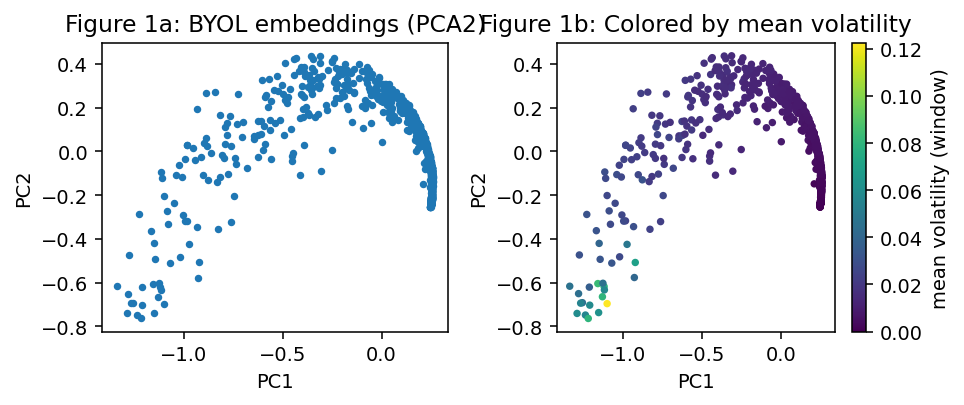

Explained variance ratio: [0.52588314 0.1633064 ]


In [9]:
pca2 = PCA(n_components=2, random_state=SEED)
pc2 = pca2.fit_transform(emb_byol)

vol_mean = vol_raw.mean(axis=1)  # 각 자산의 window 평균 vol

plt.figure(figsize=(7.0, 3.0))

plt.subplot(1, 2, 1)
plt.scatter(pc2[:,0], pc2[:,1], s=8)
plt.title("Figure 1a: BYOL embeddings (PCA2)")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.subplot(1, 2, 2)
sc = plt.scatter(pc2[:,0], pc2[:,1], c=vol_mean, s=8)
plt.colorbar(sc, label="mean volatility (window)")
plt.title("Figure 1b: Colored by mean volatility")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.tight_layout()
plt.show()

print("Explained variance ratio:", pca2.explained_variance_ratio_)


### Cell 9) Figure 2: Pairwise cosine distance distribution (BYOL vs PCA vs Random)

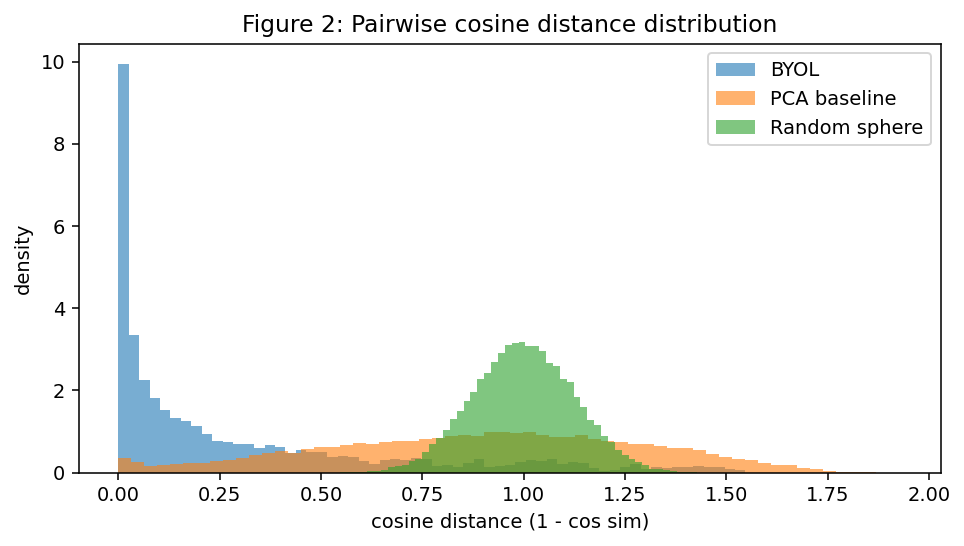

In [10]:
def sample_pairwise_cosine_dist(emb: np.ndarray, m: int = 600, max_pairs: int = 50000):
    emb = np.asarray(emb)
    N = emb.shape[0]
    m = min(m, N)
    idx = np.random.choice(N, m, replace=False) if N > m else np.arange(N)
    E = emb[idx]
    E = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)
    sim = E @ E.T
    dist = 1.0 - sim
    tri = dist[np.triu_indices(m, k=1)]
    if len(tri) > max_pairs:
        tri = np.random.choice(tri, max_pairs, replace=False)
    return tri

d_byol = sample_pairwise_cosine_dist(emb_byol)
d_pca  = sample_pairwise_cosine_dist(emb_pca)
d_rand = sample_pairwise_cosine_dist(emb_random)

plt.figure(figsize=(7,4))
plt.hist(d_byol, bins=60, alpha=0.6, density=True, label="BYOL")
plt.hist(d_pca,  bins=60, alpha=0.6, density=True, label="PCA baseline")
plt.hist(d_rand, bins=60, alpha=0.6, density=True, label="Random sphere")
plt.title("Figure 2: Pairwise cosine distance distribution")
plt.xlabel("cosine distance (1 - cos sim)")
plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()


### Cell 10) Figure 3: Index trajectory + velocity spike (^IXIC)

^IXIC rows: 753
columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']


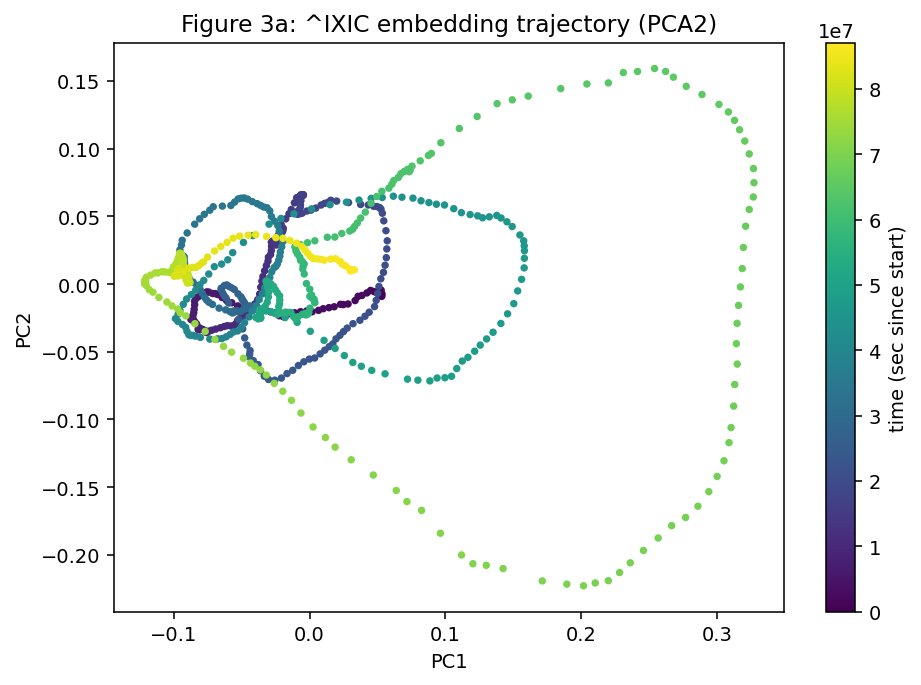

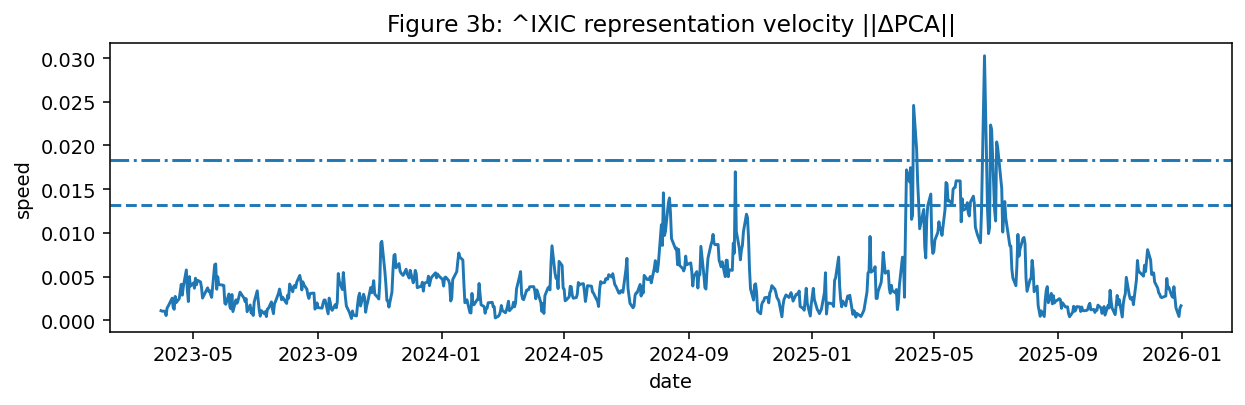

Top 5% threshold=0.0132, peak count=35
 sample peak dates: ['2024-08-07', '2024-08-12', '2024-08-13', '2024-10-17', '2025-04-04', '2025-04-07', '2025-04-08', '2025-04-11', '2025-04-14', '2025-04-15']
Top 1% threshold=0.0184, peak count=7
 sample peak dates: ['2025-04-11', '2025-04-14', '2025-06-20', '2025-06-26', '2025-06-27', '2025-07-02', '2025-07-03']
Index PCA explained variance ratio: [0.6903967  0.23093843]


In [11]:
import yfinance as yf
from sklearn.decomposition import PCA

def _normalize_yf_ohlcv(df: pd.DataFrame) -> pd.DataFrame:
    """
    yfinance가 MultiIndex 컬럼으로 주는 경우를 단일 컬럼(Open/High/Low/Close/Adj Close/Volume)로 정규화.
    """
    if isinstance(df.columns, pd.MultiIndex):
        # 보통 ('Close','^IXIC') 형태. 첫 번째 레벨만 남김: Open/High/Low/Close/Adj Close/Volume
        df = df.copy()
        df.columns = df.columns.get_level_values(0)
    return df

def build_windows_from_series(df: pd.DataFrame, window: int, vol_lookback: int, smoothing_window: int):
    df = _normalize_yf_ohlcv(df)

    # 필수 컬럼 체크
    if "Close" not in df.columns:
        print("Available columns:", df.columns)
        return None, None

    feats = make_features_from_ohlcv(
        df, vol_lookback=vol_lookback, smoothing_window=smoothing_window
    ).dropna()

    if len(feats) < window + 1:
        return None, None

    arr = feats[["lr", "vol"]].to_numpy(dtype=np.float32)  # (T,2)
    idx = feats.index

    X, dates = [], []
    for i in range(window, len(arr)):
        w = arr[i - window:i]       # (window,2)
        X.append(w.T)               # (2, window)
        dates.append(idx[i - 1])    # window 마지막 날짜

    X = torch.from_numpy(np.stack(X, axis=0))  # (N,2,window)
    dates = pd.to_datetime(pd.Series(dates))
    return X, dates

# ---------- run ----------
index_ticker = "^IXIC"
start = "2023-01-01"
end = None

df_idx = yf.download(index_ticker, start=start, end=end, interval="1d", auto_adjust=False, progress=False)
df_idx = _normalize_yf_ohlcv(df_idx).dropna()

print(index_ticker, "rows:", len(df_idx))
print("columns:", list(df_idx.columns))

X_idx, dates_idx = build_windows_from_series(df_idx, window=window, vol_lookback=vol_lookback, smoothing_window=smoothing_window)
if X_idx is None:
    raise RuntimeError("Not enough index data to build windows. (Check Close column / dropna result)")

with torch.no_grad():
    Z_idx = encoder(X_idx).numpy()  # (N, D)

pca_idx = PCA(n_components=2, random_state=SEED)
pc_idx = pca_idx.fit_transform(Z_idx)

dZ = pc_idx[1:] - pc_idx[:-1]
speed = np.linalg.norm(dZ, axis=1)
speed_dates = dates_idx.iloc[1:].reset_index(drop=True)

# 3a) trajectory time-colored
t_numeric = (dates_idx - dates_idx.min()).dt.total_seconds().to_numpy()
plt.figure(figsize=(7,5))
sc = plt.scatter(pc_idx[:, 0], pc_idx[:, 1], c=t_numeric, s=8)
plt.colorbar(sc, label="time (sec since start)")
plt.title(f"Figure 3a: {index_ticker} embedding trajectory (PCA2)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# 3b) speed over time + thresholds
plt.figure(figsize=(9,3))
plt.plot(speed_dates, speed)
for q, ls in [(0.95, "--"), (0.99, "-.")]:
    thr = float(np.quantile(speed, q))
    plt.axhline(thr, linestyle=ls)
plt.title(f"Figure 3b: {index_ticker} representation velocity ||ΔPCA||")
plt.xlabel("date"); plt.ylabel("speed")
plt.tight_layout()
plt.show()

for q in [0.95, 0.99]:
    thr = float(np.quantile(speed, q))
    peaks = speed_dates[speed >= thr]
    print(f"Top {(1-q)*100:.0f}% threshold={thr:.4f}, peak count={len(peaks)}")
    if len(peaks) > 0:
        print(" sample peak dates:", list(peaks.iloc[:10].dt.strftime("%Y-%m-%d")))

print("Index PCA explained variance ratio:", pca_idx.explained_variance_ratio_)


### Cell 11) (옵션) “BYOL이 shape이 아니라 volatility를 정렬했나?” 테스트

In [12]:
def volatility_neighbor_overlap(emb: np.ndarray, vol_windows: np.ndarray, k: int = 10):
    # emb space neighbors vs vol-space neighbors
    N = emb.shape[0]
    k = min(k, N-1)

    nn_e = NearestNeighbors(n_neighbors=k+1, metric="cosine").fit(emb)
    nn_v = NearestNeighbors(n_neighbors=k+1, metric="euclidean").fit(vol_windows)

    idx_e = nn_e.kneighbors(return_distance=False)[:, 1:]
    idx_v = nn_v.kneighbors(return_distance=False)[:, 1:]

    overlaps = []
    for i in range(N):
        overlaps.append(len(set(idx_e[i]) & set(idx_v[i])) / k)
    return float(np.mean(overlaps))

ov_ret = neighbor_overlap(emb_byol, returns_raw, k=10, emb_metric="cosine", x_metric="euclidean")
ov_vol = volatility_neighbor_overlap(emb_byol, vol_raw, k=10)

print("BYOL overlap vs returns (euclidean):", ov_ret)
print("BYOL overlap vs volatility windows:", ov_vol)


BYOL overlap vs returns (euclidean): 0.150625
BYOL overlap vs volatility windows: 0.24825000000000003
